In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  #supress tensorflow info except error
gpuNum = 2

import math
import datetime
import sys
import time
import argparse
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:  # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[gpuNum], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[gpuNum], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

from model.balance_input_fn import dataset_pipeline
from model.triplet_loss import batch_hard_triplet_loss
from model.utils import Param

4 Physical GPUs, 1 Logical GPU


In [2]:
def parse_function(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3, dct_method='INTEGER_ACCURATE')
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    image = image - 0.5
    image = image * 2.0
    image = tf.image.resize(image, [224,224])
    image = tf.expand_dims(image, axis=0)
    return image

In [3]:
baseModel = MobileNetV2(include_top=False,
                        weights=None,
                        input_shape=(224, 224, 3),
                        pooling="avg")
fc = tf.keras.layers.Dense(14,
                           activation="softmax",
                           name="dense_final")(baseModel.output)
model = Model(inputs=baseModel.input, outputs=fc)
preLayer = model.get_layer("global_average_pooling2d")
fc = tf.keras.layers.Dense(128,
                           activation=None,
                           name="embeddings")(preLayer.output)
l2 = tf.math.l2_normalize(fc)
model = Model(inputs=baseModel.input, outputs=l2)
model.load_weights("./exp/0315triplet_Ds14_2400_01/epoch-10")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [5]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

5 expanded_conv_depthwise (None, 112, 112, 32)
6 expanded_conv_depthwise_BN (None, 112, 112, 32)
7 expanded_conv_depthwise_relu (None, 112, 112, 32)
8 expanded_conv_project (None, 112, 112, 16)
9 expanded_conv_project_BN (None, 112, 112, 16)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
bn_Conv1 (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
Conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
expanded_conv_depthwise (Dep (None, 112, 112, 32)      288       
Total params: 1,280
Trainable params: 1,216
Non-trainable params: 64
________________________________________________________

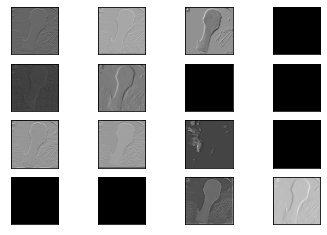

In [6]:
from matplotlib import pyplot
model = Model(inputs=model.inputs, outputs=model.layers[5].output)
img = parse_function('/home/ubuntu/dataset/Ds14_2400/test/Cow00/Cow00_0_1002.jpg')
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()